# 5.3.延后初始化


:label:`sec_deferred_init`

到目前为止，我们忽略建立网络时考虑以下这些事情：

* 我们定义了网络架构，但没有指定输入维度。
* 我们添加层时没有指定前一层的输出维度。
* 我们在初始化参数时，甚至没有足够的信息来确定模型应该包含多少参数。

你可能会对我们的代码能运行感到惊讶。
毕竟，深度学习框架无法判断网络的输入维度是什么。
这里的诀窍是框架的**延后初始化建立网络**（defers initialization），
即直到数据第一次通过模型传递时，框架才会动态地推断出每个层的大小。

在以后，当使用卷积神经网络时，
由于输入维度（即图像的分辨率）将影响每个后续层的维数，
有了该技术将更加方便(动态推出每一层的大小)。
现在我们在编写代码时无须知道维度是什么就可以设置参数，
这种能力可以大大简化定义和修改模型的任务。
接下来，我们将更深入地研究初始化机制。

## 5.3.1.实例化网络

首先，让我们实例化一个多层感知机。

此时，因为输入维数是未知的，所以网络不可能知道输入层权重的维数。


In [25]:
import torch
from torch import nn#从torch里面导入nn模块

"""延后初始化"""

'''首先，让我们实例化一个多层感知机。

此时，因为输入维数是未知的，所以网络不可能知道输入层权重的维数。'''

#用nn.sequential模块定义了两层的神经网络
net = nn.Sequential(nn.LazyLinear(256), nn.ReLU(), nn.LazyLinear(10))
#print(type(net))
#print(net[0].weight) 
print(net) # 尚未初始化


Sequential(
  (0): LazyLinear(in_features=0, out_features=256, bias=True)
  (1): ReLU()
  (2): LazyLinear(in_features=0, out_features=10, bias=True)
)



nn.lazyLinear模块的介绍:https://pytorch.org/docs/stable/generated/torch.nn.LazyLinear.html?highlight=lazylinear#torch.nn.LazyLinear

#nn.LazyLinear类似于nn.Linear()只是没有输入的维数,只有输出的维数

y=XW+b

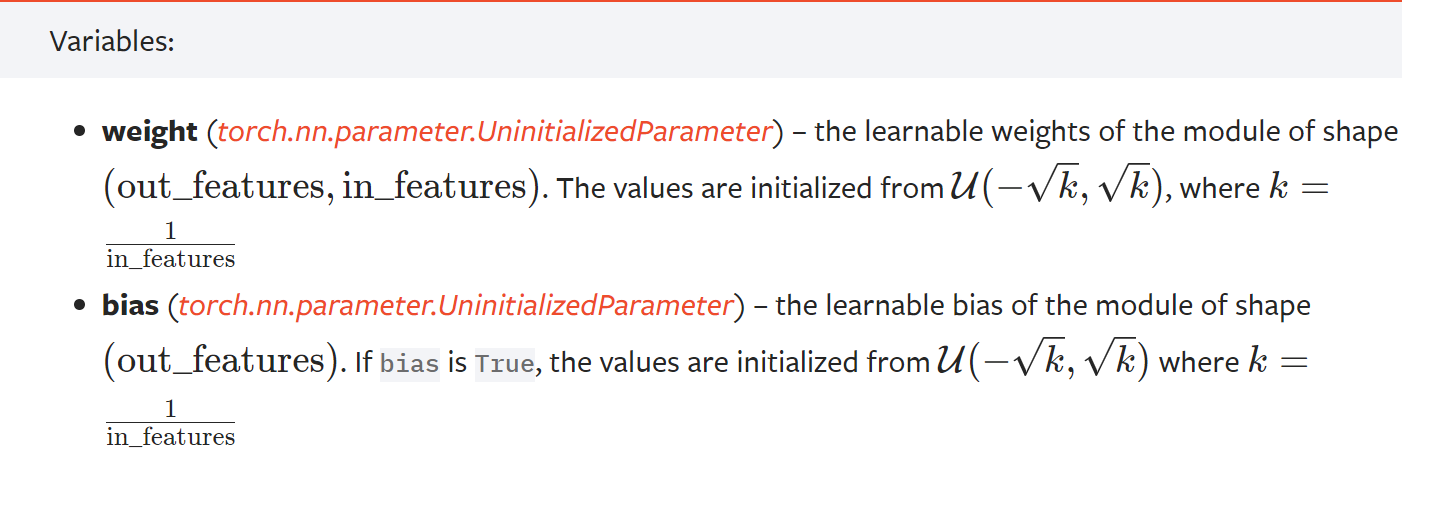

nn.sequential方法说明：https://pytorch.org/docs/stable/_modules/torch/nn/modules/container.html#Sequential

nn.Sequential是一个Sequential容器，模块将按照构造函数中传递的顺序添加到模块中。那么前一个函数的输出作为后边一个函数的输入，依次进行

有序字典：有序字典和通常字典类似，只是它可以记录元素插入其中的顺序

In [24]:
import torch.nn as nn
from collections import OrderedDict
# Sequential使用实例
#直接将一系列子模块作为参数传入
model = nn.Sequential(
          nn.Linear(1,20,5),
          nn.ReLU(),
          nn.Linear(20,64,5),
          nn.ReLU()
        )

# Sequential with OrderedDict使用实例(模块的有序字典作为传入)，不可以用名称进行访问，仍然需要用索引进行访问
model1 = nn.Sequential(OrderedDict([
          ('linear1', nn.Linear(1,20,5)),
          ('relu1', nn.ReLU()),
          ('linear2', nn.Linear(20,64,5)),
          ('relu2', nn.ReLU())
        ]))
#以上两种形式为一致。一种自动命名0，1，2，3，一种指定名字
print(model)
print(model1)
print(type(model1))
print(type(model))
model[0],model1[0]#model['linear1']报错

Sequential(
  (0): Linear(in_features=1, out_features=20, bias=True)
  (1): ReLU()
  (2): Linear(in_features=20, out_features=64, bias=True)
  (3): ReLU()
)
Sequential(
  (linear1): Linear(in_features=1, out_features=20, bias=True)
  (relu1): ReLU()
  (linear2): Linear(in_features=20, out_features=64, bias=True)
  (relu2): ReLU()
)
<class 'torch.nn.modules.container.Sequential'>
<class 'torch.nn.modules.container.Sequential'>


(Linear(in_features=1, out_features=20, bias=True),
 Linear(in_features=1, out_features=20, bias=True))

In [26]:
net[0].weight

<UninitializedParameter>

In [28]:
#接下来让我们将数据通过网络，最终使框架初始化。
X = torch.rand(2, 20)#生成[0,1]上的均匀分布
#数据第一次通过模型传递时，框架才会动态地推断出每个层的大小。
net(X)
print(net)
print(net[0].weight.data)#输出第一层的权重的值
print(net[0].bias.data[0])#输出第一层的偏执

Sequential(
  (0): Linear(in_features=20, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=10, bias=True)
)
tensor([[-0.1459,  0.1149,  0.1259,  ..., -0.1207, -0.1780, -0.0755],
        [-0.0045,  0.0526,  0.0514,  ...,  0.0328,  0.0987,  0.1750],
        [ 0.1814,  0.1539, -0.0331,  ...,  0.0777, -0.1934,  0.0977],
        ...,
        [-0.1632, -0.1842, -0.1472,  ..., -0.0148, -0.0623,  0.1392],
        [ 0.1284,  0.2120,  0.0553,  ...,  0.2169,  0.0333,  0.2032],
        [-0.1129,  0.1945, -0.1283,  ..., -0.0302,  0.0116,  0.0346]])
tensor(0.2100)


一旦我们知道输入维数是20，框架可以通过代入值20来识别第一层权重矩阵的形状。
识别出第一层的形状后，框架处理第二层，依此类推，直到所有形状都已知为止。
注意，在这种情况下，只有第一层需要延迟初始化，但是框架仍是按顺序初始化的。
等到知道了所有的参数形状，框架就可以初始化参数。

## 5.3.2.小结

* 延后初始化使框架能够自动推断参数形状，使修改模型架构变得容易，避免了一些常见的错误。
* 我们可以通过模型传递数据，使框架最终初始化参数。

## 5.3.3.练习

1. 如果你指定了第一层的输入和输出维数，但没有指定后续层的输入尺寸，会发生什么？是否立即进行初始化？
1. 如果指定了不匹配的维度会发生什么？
1. 如果输入具有不同的维度，你需要做什么？提示：查看参数绑定的相关内容。


In [30]:
#1,可以正常运行。第一层会立即初始化,但其他层同样是直到数据第一次通过模型传递才会初始化
net = nn.Sequential(
    nn.Linear(20, 256), nn.ReLU(),
    nn.LazyLinear(128), nn.ReLU(),
    nn.LazyLinear(10))
print(net)
print(net[0].weight.data[0])
print(net[2].weight)

net(X)
print(net)
print(net[2].weight.data)

Sequential(
  (0): Linear(in_features=20, out_features=256, bias=True)
  (1): ReLU()
  (2): LazyLinear(in_features=0, out_features=128, bias=True)
  (3): ReLU()
  (4): LazyLinear(in_features=0, out_features=10, bias=True)
)
tensor([-0.0259, -0.0723,  0.1925, -0.1815, -0.0224, -0.1718,  0.1421, -0.1283,
        -0.1615,  0.1543, -0.0711, -0.1228,  0.0539,  0.0759,  0.0090, -0.1870,
        -0.1288, -0.0286, -0.1215, -0.1757])
<UninitializedParameter>
Sequential(
  (0): Linear(in_features=20, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=128, bias=True)
  (3): ReLU()
  (4): Linear(in_features=128, out_features=10, bias=True)
)
tensor([[-0.0065,  0.0414,  0.0546,  ..., -0.0107,  0.0382,  0.0533],
        [-0.0613,  0.0385, -0.0251,  ...,  0.0585, -0.0495,  0.0496],
        [ 0.0254,  0.0082, -0.0228,  ...,  0.0199,  0.0175, -0.0046],
        ...,
        [ 0.0243, -0.0608, -0.0090,  ...,  0.0149,  0.0028,  0.0216],
        [ 0.0426,  0.0450,  0.046

In [6]:
#2: 会由于矩阵乘法的维度不匹配而报错

X = torch.rand(2, 10)
net(X)
#mat1 and mat2 shapes cannot be multiplied (2x10 and 20x256)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (2x10 and 20x256)

## python基础：面向对象

实例属性：修饰对象的属性，定义在魔法方法__init__的里面，定义方法：self.XX。并且每一个对象拥有的单独的属性 访问方法：对象名.属性,不能用类进行访问

类属性：修饰类的属性， 直接在类的内部进行定义。访问方式:类和对象都可以访问，类名.属性，对象名.属性

实例方法：修饰对象的方法：定义在类的内部，直接通过**函数**进行定义，访问方式：对象名.方法

类方法：修饰类的方法：定义类的内部需要添加装饰器定义@classmethod通过函数定义，访问：类，对象都可以访问

__init__()是魔法方法，是特殊的实例方法，作用是初始化对象。


In [28]:
#定义类，创建对象和实例化
class 类名():
    姓名='zhang' #类属性。类属性就相当与全局变量，实例对象共有的属性。在实例属性中调用的方式：self.XX
    年龄=0
    def __init__(self):
        #在实例方法中定义的变量称实例属性
        self.实例属性=1
    def 实例方法(self):
        print(f'你的名字是{self.姓名}')
        print(f'你的年龄是{self.年龄}')
    def 实例方法1(self,x):
        return x
对象名=类名()#创建对象
对象名.实例方法()#实例化
print(对象名.实例方法1(2))#实例化
#调用类属性
print(对象名.姓名)
print(类名.姓名)
#调用实例属性
print(对象名.实例属性)
#print(类名.实例属性)#报错，无法通过类名访问实例属性

你的名字是zhang
你的年龄是0
2
zhang
zhang
1


In [2]:
#魔法方法__init__()
class 类名():#定义类
    姓名='z' #类属性。类属性就相当与全局变量，实例对象共有的属性。在实例属性中调用的方式：self.XX
    年龄=0
    def __init__(self,姓名,年龄):#是一种魔法方法，又称构造函数（特殊的实例方法）在创建对象时自动调用，不需要手动调用，__init__作用是初始化参数
        self.姓名=self.姓名#左边定义的self.XX是实例属性，实例属性为实例对象自己私有，右边的是类属性也就是上面的姓名。
        self.姓名1=姓名#左边定义的self.XX是实例属性，右边的是init魔法方法中传入的参数
        self.年龄=年龄
    def 实例方法(self):
        print(f'你的名字是{self.姓名}')
        print(f'你的名字是{self.姓名1}')
        print(f'你的年龄是{self.年龄}')
        
对象名=类名('zhang',2)#创建对象的方法
对象名.实例方法()#实例化
print(对象名.姓名)

你的名字是z
你的名字是zhang
你的年龄是2
z


In [2]:
#创建多个对象
class 类名():#定义类
    def __init__(self,姓名,年龄):
        self.姓名=姓名 #self.姓名是指对象名字，后面是输入的参数
        self.年龄=年龄
    def 实例方法(self):
        print(f'你的名字是{self.姓名}')
        print(f'你的年龄是{self.年龄}')

#一个类可以创建多个对象，但不同对象存储的地址不同。
#当对象1=类名时，那么self就是对象1，也就是对象1.姓名=张辰，对象1.Nianliang=22
#之后self=对象2，以此类推
对象名1=类名('z','22')#创建对象
对象名1.实例方法()#实例化

对象名2=类名('w','16')
对象名2.实例方法()

你的名字是z
你的年龄是22
你的名字是w
你的年龄是16


In [7]:
#继承：子类拥有父类当中所有属性和方法的使用权
#单继承
#在Python中，所有的类默认继承object类，object类是顶级类或者基类；其他的子类叫做派生类
class 小头爸爸(object):#父类
    age=12#类属性
    def __init__(self):
        #我们将在实例方法中定义的变量成为实例属性
        self.年龄=30#创建了实例属性
    def 实例方法(self):
        print(f'小头爸爸的年龄是{self.年龄}')
class 大头儿子(小头爸爸):#将小头儿子代替object就说明小头爸爸是父类，大头儿子是子类，子类拥有父类当中所有属性和方法的使用权
    pass #占位符，没有就会报错


对象名1=小头爸爸()#创建了父类对象
对象名1.实例方法()#父类中的实例方法，调用类中的实例方法的方法

对象名=大头儿子()#创建子类对象，self=对象名
对象名.实例方法()#这里是父类中的实例方法
print(对象名.age)
print(对象名.年龄)

小头爸爸的年龄是30
小头爸爸的年龄是30
12
30


In [22]:
#面向对象：多继承（子类继承了多个父类），当一个子类有多个父类的时候默认使用第一个父类同名的属性和方法
class 父类1(object):
    def __init__(self):
        self.姓名='z'
        self.年龄=12
        
    def 实例方法1(self):
        print(f'姓名{self.姓名}')

class 父类2(object):
    def __init__(self):
        self.年龄=11
        
    def 实例方法2(self):
        print(f'年龄{self.年龄}')

class 子类(父类1,父类2):
    pass
对象=子类()
对象.实例方法2()
对象.实例方法1()
#如果不在父类1中加入self.年龄=12，就会出错,因为在多继承的时候两个父类都有__init__方法，所以默认使用第一个的，那么需要加上self.年龄=12

年龄12
姓名z


In [26]:
#子类与父类拥有同名的属性和方法，默认使用子类的同名属性和方法
#子类->父类1，父类2（同级）->object
class 父类1(object):
    def __init__(self):
        self.姓名='zhang'
        
    def 实例方法(self):
        print(f'名字{sself.姓名}')

class 父类2(object):
    def __init__(self):
        self.年龄=11
        
    def 实例方法(self):
        print(f'姓名{self.年龄}')

class 子类(父类1,父类2):
    def __init__(self):
        self.时间=22
        
    def 实例方法(self):
        print(f'时间{self.时间}')
对象=子类()
对象.实例方法()


时间22


In [1]:
#当子类中有与父类相同的属性和方法的时候使用super()调用父类的属性和方法
#super()用来调用父类(基类)的方法，__init__()是类的构造方法，
#super().__init__() 就是调用父类的init方法， 同样可以使用super()去调用父类的其他方法。
#大宝->张辰->李小龙->叶问->object
class fulei1(object):
    def __init__(self):
        self.姓名='zhan'
        
    def 实例方法(self):
        print(f'使用{self.姓名}')

class zilei1(fulei1):
    def __init__(self):
        self.年龄=12
        
    def 实例方法(self):
        print(f'使用{self.年龄}')
        #下面说明利用superr()在子类1中调用其父类的实例方法
        #如果fulei1上面还有父类，我们想继续调用其父类的实例方法可以继续在父类的实例方法中加入super()函数
        super().__init__()
        super().实例方法()

class zilei2(zilei1):
    def __init__(self):
        self.身份='学生'
        
    def 实例方法(self):
        self.__init__()
        print(f'使用{self.身份}')
        
    def fulei1_实例方法(self):
        fulei1.__init__(self)
        fulei1.实例方法(self)
    def zilei1_实例方法(self):
        zilei1.__init__(self)
        zilei1.实例方法(self)
    
    def fulei1和zilei1的实例方法(self):
        #下面说明利用superr()在zilei2中调用其父类fulei1的实例方法
        super().__init__()
        super().实例方法()

对象=zilei2()
对象.fulei1和zilei1的实例方法()

使用12
使用zhan


# 5.4自定义层 
**回顾：**
**层**
（1）接受一组输入，

（2）生成相应的输出，

（3）由一组可调整参数描述。

对于多层感知机而言，整个模型及其组成层都是这种架构：
整个模型接受原始输入（特征），生成输出（预测），
并包含一些参数（所有组成层的参数集合）。
同样，每个单独的层接收输入（由前一层提供），
生成输出（到下一层的输入），并且具有一组可调参数，
这些参数根据从下一层反向传播的信号进行更新。
比如我们定义的包含一个隐藏层的多层感知机nn.Sequential(nn.Linear(2,64),nn.ReLU(),nn.Linear(64,1))，第一个是输入层，第二个是输出层。

深度学习成功背后的一个因素是神经网络的灵活性：
我们可以用创造性的方式组合不同的层，从而设计出适用于各种任务的架构。
例如，研究人员发明了专门用于处理图像、文本、序列数据和执行动态规划的层。
未来，你会遇到或要自己发明一个现在在深度学习框架中还不存在的层。
在这些情况下，你必须构建自定义层。在本节中，我将分享如何构建层。

层和块的构造类似，都是需要继承nn.module模块的类。

## 5.4.1.不带参数的层



首先，我们(**构造一个没有任何参数的自定义层**)。
如果你还记得我们在 5.1节对块的介绍，
这应该看起来很眼熟。
下面的`CenteredLayer`类要从其输入中减去均值。
要构建它，根据前面的介绍我们只需继承基础层类并实现前向传播功能。

**基础类nn.module**:

（1）torch.nn Pytorch nn模块提供了创建和训练神经网络的各种工具，其专门为深度学习设计。核心的数据结构是Module。Module是一个抽象的概念，既可以表示神经网络中的某个层，也可以表示一个包含很多层的神经网络。

（2）nn.Module 是nn中重要的类，其包含网络各层的定义函数，即：__init__(self)，以及前向传递函数def forward(self,x)

nn.module模块官网说明:https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module

（1）所有神经网络模块的基础类

（2）在定义模型的时候必须要继承nn.Module类

（3）模块也可以包括其他的模块（Modules can also contain other Modules）

    class Model(nn.Module):#本身是一个Module
        def __init__(self):
            super().__init__()
            self.conv1 = nn.Conv2d(1, 20, 5)#卷积神经网络nn.Conv2d是nn.Module的子Module
            self.conv2 = nn.Conv2d(20, 20, 5)

        def forward(self, x):
            x = F.relu(self.conv1(x))
            return F.relu(self.conv2(x))

**torch.nn.functional**里面包含了神经网络所需要的各种函数（比如：激活函数ReLU(),交叉熵损失函数）。

torch.nn.functional的官网：https://pytorch.org/docs/stable/nn.functional.html#loss-functions

**torch.nn与torch.nn.functiona之间的联系和区别**其实这两个的实际功能是差不多的，不过一个包装好的类，一个是可以直接调用的函数。

区别：https://www.zhihu.com/question/66782101

https://blog.csdn.net/GZHermit/article/details/78730856

variable是可以学习的参数，因为下面用到了Relu激活函数没有可以进行学习的参数所以就用nn.functional

In [33]:
import torch
import torch.nn.functional as F#导入torch.nn.module模块，将torch.nn.functional模块命名为F
from torch import nn
class CenteredLayer(nn.Module):#定义了一个Centeredlaye类它继承了nn.Module模块
    def __init__(self):
        #继承父类的__init__函数，可以省去重复编写代码的痛苦，没有就会报错
        super().__init__()
    
    def forward(self,x):#定义向前传播函数
        return x-x.mean()

In [34]:
#让我们向该层提供一些数据，验证它是否能按预期工作。
layer=CenteredLayer()#创建对象
layer(torch.FloatTensor([1,2,3,4,5]))#浮点型的张量，实例化对象,调用向前传播函数
#没用layer.forward(torch.FloatTensor([1,2,3,4,5]))的原因:layer(torch.FloatTensor([1,2,3,4,5]))相当于layer.__call__(torch.FloatTensor([1,2,3,4,5])),nn.module中的__call__()中调用了forward函数
#在继承了nn.Module类之后，模型训练时，不需要调用forward这个函数，只需要在实例化一个对象中传入对应的参数就可以自动调用 forward 函数。
   #原因：https://zhuanlan.zhihu.com/p/356059224


tensor([-2., -1.,  0.,  1.,  2.])

现在，我们可以[**将层作为组件合并到更复杂的模型中**]。就是将我们创建的层组合成块

In [35]:
net=nn.Sequential(nn.Linear(8,128),CenteredLayer())

作为额外的健全性检查，我们可以在向该网络发送随机数据后，检查均值是否为0。
由于我们处理的是浮点数，因为存储精度的原因，我们仍然可能会看到一个非常小的非零数。
​

In [36]:
Y=net(torch.rand(4,8))#服从（0，1）上均匀分布的4*8的张量作为输入传到网络中
print(Y.shape)
Y.mean()#均值在样本量较大的情况下可以估计随机变量的期望，因为X的独立同分布的，所以X-X的均值(X是微微的张量，X的均值X中所有元素的均值)的期望为零

torch.Size([4, 128])


tensor(4.6566e-09, grad_fn=<MeanBackward0>)

## 5.4.2.[**带参数的层**]

以上我们知道了如何定义简单的层，下面我们继续定义具有参数的层，
这些参数可以通过训练进行调整。
我们可以使用内置函数（__init__函数）来创建参数，这些函数提供一些基本的管理功能。
比如管理访问、初始化、共享、保存和加载模型参数。
这样做的好处之一是：我们不需要为每个自定义层编写自定义的序列化程序。

现在，让我们实现自定义版本的全连接层。
回想一下，该层需要两个可学习的参数，一个用于表示权重，另一个用于表示偏置项。
在此实现中，我们使用ReLU()函数作为激活函数。
建立的全连接层需要输入参数：`in_units`和`units`，分别表示输入数和输出数。

**我们定义了一个简单的层，该层相当于一个含有激活函数ReLU的隐藏层，并且能够改变输入数和输出数，并且隐藏层的权重和偏置也是自己定义的（权重和偏执按照标准正态分布进行随机初始化的）**


In [18]:
class MyLinear(nn.Module):# MyLinear的父类是nn.Modul
    def __init__(self,in_units,units):#in_units,units是两个输入参数
        super().__init__()#继承父类的__init__
        #没有nn.Parameter，linear.weight结果中就没有梯度无法进行反向传播计算
        self.weight=nn.Parameter(torch.randn(in_units,units))#生成了in_units*units的服从标准正态分布的随机数，nn.Parameter模块会对传入的参数torch.randn(in_units,units)自动加上梯度，那么就可以通过反向传播函数进行更新参数(权重和偏置)，实现训练目的
        #偏置，但一般将偏置设为0,我们这里只是为了举个例子，并没有实际意义
        self.bias=nn.Parameter(torch.randn(units,))##生成了长度为units的服从标准正态分布的随机向量，也可以nn.Parameter(torch.randn(units))

    def forward(self,x):
        linear=torch.matmul(x,self.weight.data)+self.bias.data#去掉了梯度，如果直接是self.weight那么包含了梯度,因为我们的linear不需要调用反向传播函数进行更新所以去掉了梯度。
        return F.relu(linear)#对linear调用激活函数，类似于带有激活函数RelLU的隐藏层

print(torch.randn(5,).shape)#是一个一维的张量
print(torch.randn(5).shape)#是一个一维的张量
print(torch.randn(5,1).shape)#是个二维的张量

torch.Size([5])
torch.Size([5])
torch.Size([5, 1])


### nn.Parameters()函数的简单介绍
**首先可以把这个函数理解为类型转换函数，将一个不可训练的类型Tensor转换成可以训练的类型parameter并将这个parameter绑定到这个module里面**

链接：https://www.jianshu.com/p/d8b77cc02410


上面就定义了一个线性全连接层，我们可以自己改变输入和输出。接下来，我们实例化`MyLinear`类并访问其模型参数

In [37]:
linear=MyLinear(5,3)#类中的self看作linear,in_units=5,unites=3,
linear.weight#访问实例属性

Parameter containing:
tensor([[ 2.1237,  0.6036,  0.3364],
        [ 0.0682, -0.1453,  0.4323],
        [-0.2034,  1.1194, -0.7449],
        [-0.9178,  0.3019,  0.4327],
        [-0.3735, -1.1079,  0.4611]], requires_grad=True)

我们可以[**使用自定义层直接执行前向传播计算**]。


In [38]:
linear(torch.rand(2,5))#linear是一个输入数是5，输出数是3，所以输出的结果是2*3的二位张量
#只要继承了nn.module类模型训练时，不需要调用forward这个函数，只需要在实例化一个对象中传入对应的参数就可以自动调用 forward 函数。

tensor([[0.0000, 0.0000, 0.6193],
        [0.0000, 0.3062, 0.0000]])

我们还可以(**使用自定义层构建模型**)，就像使用内置的全连接层(nn.Linear)一样使用自定义层。


In [40]:
net=nn.Sequential(MyLinear(64,8),MyLinear(8,1))#第一个第二个是我们自己定义的层
print(net(torch.rand(2,64)))#实例化之后调用前向传播函数

tensor([[0.],
        [0.]])


## 小结

* 我们可以通过基本层类设计自定义层。这允许我们定义灵活的新层，其行为与深度学习框架中的任何现有层不同。
* 在自定义层定义完成后，我们就可以在任意环境和网络架构中调用该自定义层。
* 层可以有局部参数，这些参数可以通过内置函数创建。

